# Exercise 6.3: Neural Networks in Keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# See https://keras.io/
# for extennsive documentation
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

plt.style.use("seaborn-v0_8")

2025-11-14 13:52:16.325704: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-14 13:52:16.345606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763124736.370955  887707 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763124736.379719  887707 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763124736.399175  887707 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Let us visit the problem of wine quality prediction previously encountered one final time. After linear regression and a self-made network, we can now explore the comfort provided by the Keras library.

In [3]:
# The code snippet below is responsible for downloading the dataset to
# Google. You can directly download the file using the link
# if you work with a local anaconda setup
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv --no-check-certificate

--2025-11-14 13:52:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘winequality-white.csv’

winequality-white.c     [   <=>              ] 258,23K   388KB/s    in 0,7s    

2025-11-14 13:52:22 (388 KB/s) - ‘winequality-white.csv’ saved [264426]



In [4]:
# load all examples from the file
data = np.genfromtxt("winequality-white.csv", delimiter=";", skip_header=1)

print(f"{data.shape = } \n")

# Prepare for proper training
rng = np.random.default_rng(1234)
rng.shuffle(data)  # randomly sort examples

# take the first 3000 examples for training
# (remember array slicing from last week)
X_train = data[:3000, :11]  # all features except last column
y_train = data[:3000, 11]  # quality column

# and the remaining examples for testing
X_test = data[3000:, :11]  # all features except last column
y_test = data[3000:, 11]  # quality column

mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
print("Mean shape: ", mean.shape)
# normalize
data = (data-mean)/std

print("First example:")
print("Features:", X_train[0])
print("Quality:", y_train[0])

data.shape = (4898, 12) 

Mean shape:  (12,)
First example:
Features: [6.8000e+00 1.9000e-01 7.1000e-01 1.7500e+01 4.2000e-02 2.1000e+01
 1.1400e+02 9.9784e-01 2.8500e+00 5.0000e-01 9.5000e+00]
Quality: 6.0


Below is the simple network from exercise 4.1 implemented using Keras. In addition to the network we define the loss function and optimiser.

In [5]:
# See: https://keras.io/api/models/sequential/ and
# https://keras.io/api/layers/core_layers/dense/
# We can use the Sequential class to very easiliy

## Model 1: Baseline
nb_nodes = 20
nb_layers = 2
activation = "relu"

# build a simple architecture
model_basic = Sequential()
# 11 inputs, 20 outputs, relu
model_basic.add(Dense(nb_nodes, input_dim=11, activation=activation))
# 20 inputs (automatically detected by Keras), 1 output, linear activation

for i in range(1, nb_layers):
    model_basic.add(Dense(nb_nodes, activation=activation))

model_basic.add(Dense(1, activation='linear'))

adam = keras.optimizers.Adam(learning_rate=0.001)

# Set loss function and optimiser algorithm
model_basic.compile(
    loss='mse',  # mean squared error
    optimizer=adam # stochastic gradient descent
)

## Model 2: Optimized
nb_nodes_opt = 50
nb_layers_opt = 4
activation_opt = "relu"

model_opt = Sequential()

model_opt.add(Dense(nb_nodes_opt, input_dim=11, activation=activation_opt))

# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

for i in range(1, nb_layers_opt):
    model_opt.add(Dense(nb_nodes_opt, activation=activation_opt, kernel_regularizer=l2(0.001)))
    # model_opt.add(Dropout(0.3))

model_opt.add(Dense(1, activation='linear'))

adam = keras.optimizers.Adam(learning_rate=0.001)

model_opt.compile(
    loss='mse',  # mean squared error
    optimizer=adam # stochastic gradient descent
)

/home/damian/miniforge3/envs/adl/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1763124747.198566  887707 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46857 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6
I0000 00:00:1763124747.199430  887707 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46765 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:b3:00.0, compute capability: 8.6


# Training and evaluation below

The code below trains the network for 5 epochs using the loss function and optimiser defined above. Each example is individually passed to the network

In [6]:
history_basic = model_basic.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=64)

Epoch 1/100


I0000 00:00:1763124753.412504  890783 service.cc:152] XLA service 0x7f6ab4004f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763124753.412556  890783 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1763124753.412566  890783 service.cc:160]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-11-14 13:52:33.468397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763124753.625800  890783 cuda_dnn.cc:529] Loaded cuDNN version 91002


34/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1665

I0000 00:00:1763124755.760304  890783 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 1.7601 - val_loss: 0.8351
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8011 - val_loss: 0.7067
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7358 - val_loss: 0.6529
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7112 - val_loss: 0.6543
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6889 - val_loss: 0.6474
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6903 - val_loss: 0.6932
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7092 - val_loss: 0.6274
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6991 - val_loss: 0.7639
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6996 - val_loss: 0.7092
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6842 - val_loss: 0.6058
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7016 - val_loss: 0.6804
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6

In [7]:
history_opt = model_opt.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100, batch_size=64)

Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 8.9714 - val_loss: 3.6723
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1519 - val_loss: 1.0186
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9245 - val_loss: 0.8467
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7549 - val_loss: 0.7213
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7105 - val_loss: 0.6865
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7216 - val_loss: 0.7242
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7895 - val_loss: 0.9102
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7367 - val_loss: 0.8569
Epoch 9/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7456 - val_loss: 0.7550
Epoch 10/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7410 - val_loss: 0.6772
Epoch 11/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7134 - val_loss: 0.7294
Epoch 12/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/st

In [8]:
# The history object returned by the model training above
# contains the values of the loss function (the mean-squared-error)
# at different epochs
# We discard the first epoch as the loss value is very high,
# obscuring the rest of the distribution
train_loss_basic = history_basic.history["loss"][1:]
test_loss_basic  = history_basic.history["val_loss"][1:]
train_loss_opt   = history_opt.history["loss"][1:]
test_loss_opt    = history_opt.history["val_loss"][1:]

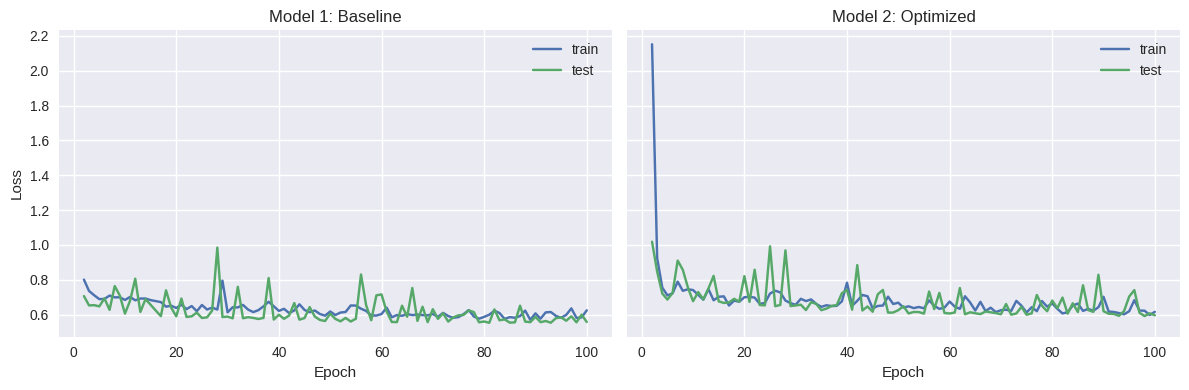

In [9]:
epochs_basic = range(2, 2 + len(train_loss_basic))
epochs_opt   = range(2, 2 + len(train_loss_opt))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# --- Basic ---
axes[0].plot(epochs_basic, train_loss_basic, label="train")
axes[0].plot(epochs_basic, test_loss_basic, label="test")
axes[0].set_title("Model 1: Baseline")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

# --- Optimized ---
axes[1].plot(epochs_opt, train_loss_opt, label="train")
axes[1].plot(epochs_opt, test_loss_opt, label="test")
axes[1].set_title("Model 2: Optimized")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


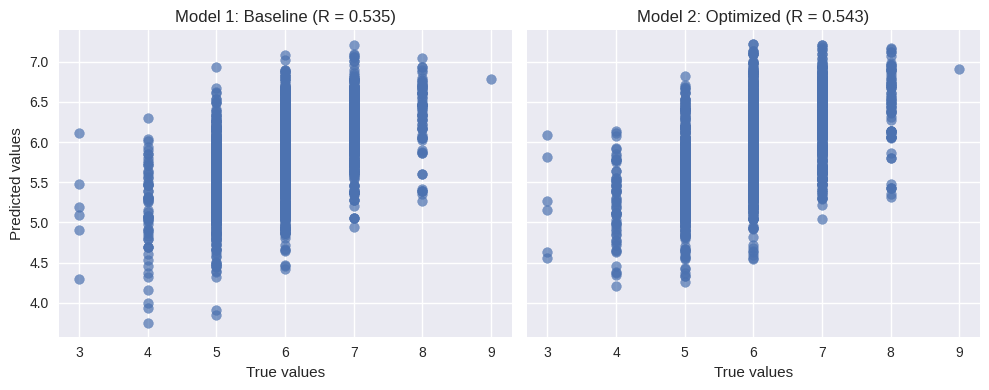

In [10]:
y_pred_basic = model_basic.predict(X_test)[:, 0]
y_pred_opt   = model_opt.predict(X_test)[:, 0]

corr_basic = np.corrcoef(y_pred_basic, y_test)[0, 1]
corr_opt   = np.corrcoef(y_pred_opt, y_test)[0, 1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# --- Basic ---
axes[0].scatter(y_test, y_pred_basic, alpha=0.7)
axes[0].set_title(f"Model 1: Baseline (R = {corr_basic:.3f})")
axes[0].set_xlabel("True values")
axes[0].set_ylabel("Predicted values")

# --- Optimized ---
axes[1].scatter(y_test, y_pred_opt, alpha=0.7)
axes[1].set_title(f"Model 2: Optimized (R = {corr_opt:.3f})")
axes[1].set_xlabel("True values")

plt.tight_layout()
plt.show()

In [ ]:
corr_base = np.corrcoef(y_pred_basic, y_test)[0, 1]
corr_opt = np.corrcoef(y_pred_opt, y_test)[0, 1]

print(f"Correlation (base model):       {corr_base:.4f}")
print(f"Correlation (optimized model):  {corr_opt:.4f}")


Correlation (base model):       0.5346
Correlation (optimized model):  0.5433


: 


# Problems

* Use the notebook as starting point. It already contains the simple network from Exercise 4.1 implemented in Keras.

* Currently, SGD is used without momentum. Try training with a momentum term. Replace SGD with the Adam optimizer and train using that. (See: https://keras.io/api/optimizers/)
* Add two more hidden layers to the network (you can choose the number of nodes but make sure to apply the ReLu activation function after each) and train again.
* Test differet numbers of examples (i.e. change the batch batch size) to be simulataneously used by the network.
* (bonus) optimize the network architecture to get the best correlation coefficient. (Let's see who gets the most out of the data).